In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 23 16:27:15 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#DCGAN
Code from the paper "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks". 

#Dataset
I'll be using the CelebA dataset as the ground truth for the probability distribution. The GAN will be trained to generate faces.

In [ ]:
!gdown --id 12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg

Downloading...
From: https://drive.google.com/uc?id=12rFbtWMg1NUCW4JKm_dwBpGdb6e-BuHg
To: /content/CelebA.zip
100% 1.44G/1.44G [00:08<00:00, 173MB/s]


In [ ]:
!unzip "/content/CelebA.zip" -d "/content/CelebA"

Streaming output truncated to the last 5000 lines.
 extracting: /content/CelebA/img_align_celeba/197600.jpg  
 extracting: /content/CelebA/img_align_celeba/197601.jpg  
 extracting: /content/CelebA/img_align_celeba/197602.jpg  
 extracting: /content/CelebA/img_align_celeba/197603.jpg  
 extracting: /content/CelebA/img_align_celeba/197604.jpg  
 extracting: /content/CelebA/img_align_celeba/197605.jpg  
 extracting: /content/CelebA/img_align_celeba/197606.jpg  
 extracting: /content/CelebA/img_align_celeba/197607.jpg  
 extracting: /content/CelebA/img_align_celeba/197608.jpg  
 extracting: /content/CelebA/img_align_celeba/197609.jpg  
 extracting: /content/CelebA/img_align_celeba/197610.jpg  
 extracting: /content/CelebA/img_align_celeba/197611.jpg  
 extracting: /content/CelebA/img_align_celeba/197612.jpg  
 extracting: /content/CelebA/img_align_celeba/197613.jpg  
 extracting: /content/CelebA/img_align_celeba/197614.jpg  
 extracting: /content/CelebA/img_align_celeba/197615.jpg  
 extr

In [ ]:
!pip install tensorflow
!pip install tensorflow_datasets

In [ ]:
!sudo du CelebA
!sudo ls CelebA/img_align_celeba | wc -l

1743716	CelebA/img_align_celeba
1743720	CelebA
202599


In [ ]:
!pip install opencv-python

(218, 178, 3)


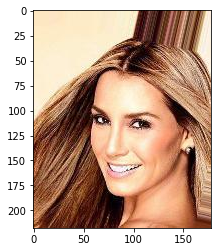

In [ ]:
# Test image read

import cv2
import matplotlib.pyplot as plt

# Read in image as ndarray
img = cv2.imread('CelebA/img_align_celeba/000001.jpg')
# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Starting images are 178px resolution
print(img.shape)

# print(img)
plt.imshow(img)

(178, 178, 3)


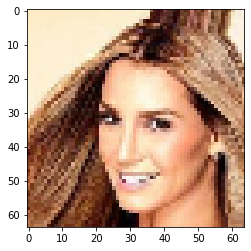

In [ ]:

original_img = cv2.imread('CelebA/img_align_celeba/000001.jpg')

# Crop out top and bottom evenly to create a square image
crop_margin = int((original_img.shape[0] - original_img.shape[1]) / 2)
original_img = original_img[crop_margin:(original_img.shape[0] - crop_margin)]

print(original_img.shape)

# Resize to 64x64
img = cv2.resize(original_img, (64, 64))

# BGR -> RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.imshow(img)

In [ ]:
!pip install tqdm

In [ ]:
# I'm only going to take a subset of the data for now for training

SUBSET_AMOUNT = 10000
SUBSET_AMOUNT = 202599

In [ ]:
import tensorflow as tf

# Load in all file names

directory = r'/content/CelebA/img_align_celeba'
list_ds = tf.data.Dataset.list_files(str(directory+'*/*'), shuffle=True)

In [ ]:
import os

filenames_list = os.listdir(directory)

In [ ]:
for i in filenames_list[:5]:
  print(i)

print("Number of files to read:", len(filenames_list))

026885.jpg
123631.jpg
125585.jpg
003685.jpg
006459.jpg
Number of files to read: 202599


In [ ]:
def test_map_function(string):
  print(string + 'TEST')
  return string + 'TEST'

for i in map(test_map_function, filenames_list[:5]):
  print(i)

026885.jpgTEST
026885.jpgTEST
123631.jpgTEST
123631.jpgTEST
125585.jpgTEST
125585.jpgTEST
003685.jpgTEST
003685.jpgTEST
006459.jpgTEST
006459.jpgTEST


In [ ]:
for i in list_ds.take(5):
  print(i.numpy())

b'/content/CelebA/img_align_celeba/201701.jpg'
b'/content/CelebA/img_align_celeba/025504.jpg'
b'/content/CelebA/img_align_celeba/108499.jpg'
b'/content/CelebA/img_align_celeba/188706.jpg'
b'/content/CelebA/img_align_celeba/132741.jpg'


In [ ]:
def test_convert(string):
  print(string + 'WORKING')
  return string + 'WORKING'

for i in list_ds.take(5).map(test_convert, num_parallel_calls=tf.data.AUTOTUNE):
  print(i)

Tensor("add:0", shape=(), dtype=string)
tf.Tensor(b'/content/CelebA/img_align_celeba/130224.jpgWORKING', shape=(), dtype=string)
tf.Tensor(b'/content/CelebA/img_align_celeba/175781.jpgWORKING', shape=(), dtype=string)
tf.Tensor(b'/content/CelebA/img_align_celeba/029431.jpgWORKING', shape=(), dtype=string)
tf.Tensor(b'/content/CelebA/img_align_celeba/197996.jpgWORKING', shape=(), dtype=string)
tf.Tensor(b'/content/CelebA/img_align_celeba/042394.jpgWORKING', shape=(), dtype=string)


In [ ]:
import numpy as np

np_filenames_list = np.array(filenames_list)

for i in map(test_map_function, np_filenames_list[:5]):
  print(i)

026885.jpgTEST
026885.jpgTEST
123631.jpgTEST
123631.jpgTEST
125585.jpgTEST
125585.jpgTEST
003685.jpgTEST
003685.jpgTEST
006459.jpgTEST
006459.jpgTEST


In [ ]:
# Image getting and processing callback: 
# from image path, get processed 64x64 image
def img_path2data(img_path):

  # print(tf.strings.as_string(img_path))
  # print(tf.io.decode_raw(img_path, tf.uint8))
  # print(type(img_path))
  # if img_path.endswith('.jpg'):

  # Read in image as ndarray
  # print(img_path)
  img = cv2.imread(directory + '/' + img_path)
  # img = tf.io.read_file(img_path)
  # img = tf.io.decode_jpeg(img)

  # Crop out top and bottom evenly to create a square image
  crop_margin = int((img.shape[0] - img.shape[1]) / 2)
  img = img[crop_margin:(img.shape[0] - crop_margin)]

  # Resize to 64x64
  img = cv2.resize(img, (64, 64))

  # BGR -> RGB
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

  # Normalize from [0, 255] to [-1, 1]
  img = (img / (255.0/2)) - 1.0

  return img

In [ ]:
map_test = map(img_path2data, filenames_list)

In [ ]:
print(type(map_test))

<class 'map'>


In [ ]:
# Read images as dataset

from tqdm import tqdm
import tensorflow_datasets as tfds

SUBSET_AMOUNT = 100000

# print(type(tfds.as_numpy(list_ds)))
# print(list_ds.element_spec)
# ds = list_ds.map(img_path2data, num_parallel_calls=tf.data.AUTOTUNE)
# for i in map(img_path2data, filenames_list):
#   print(i)
# ds = list(tqdm(map(img_path2data, filenames_list[:100000])))
# ds = np.array(ds)
# ds = tf.data.Dataset.from_tensor_slices(ds)
ds = tf.data.Dataset.from_tensor_slices(list(tqdm(map(img_path2data, 
                                                      filenames_list[:100000]))))

100000it [01:11, 1392.84it/s]


In [ ]:
# Move all pixel values into the range [-1, 1] (the range of tanh)

# ds = (ds / (255.0/2)) - 1.0

In [ ]:
BATCH_SIZE = 128

# Batch dataset

# dataset = tf.data.Dataset.from_tensor_slices(ds)

ds = ds.batch(BATCH_SIZE)

In [ ]:
for i in ds.take(2):
  print(i)

tf.Tensor(
[[[[ 0.38039216  0.39607843  0.38823529]
   [ 0.38823529  0.40392157  0.38823529]
   [ 0.38823529  0.40392157  0.39607843]
   ...
   [ 0.52156863  0.52156863  0.52156863]
   [ 0.55294118  0.55294118  0.55294118]
   [ 0.58431373  0.58431373  0.58431373]]

  [[ 0.37254902  0.38039216  0.38039216]
   [ 0.37254902  0.38823529  0.38039216]
   [ 0.37254902  0.38823529  0.38039216]
   ...
   [ 0.52156863  0.52156863  0.52156863]
   [ 0.55294118  0.55294118  0.55294118]
   [ 0.55294118  0.55294118  0.55294118]]

  [[ 0.37254902  0.38823529  0.38039216]
   [ 0.37254902  0.38823529  0.38039216]
   [ 0.37254902  0.38823529  0.38039216]
   ...
   [ 0.5372549   0.5372549   0.5372549 ]
   [ 0.55294118  0.55294118  0.55294118]
   [ 0.56078431  0.56078431  0.56078431]]

  ...

  [[-0.45098039 -0.67843137 -0.76470588]
   [-0.42745098 -0.67843137 -0.76470588]
   [-0.21568627 -0.49803922 -0.59215686]
   ...
   [ 0.31764706  0.23921569  0.14509804]
   [ 0.35686275  0.3254902   0.27843137]
   [ 

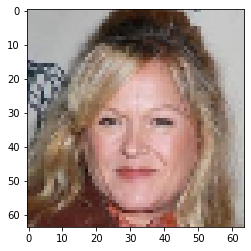

In [ ]:
for i in ds.take(1):
  _ = (i+1.0)/2

plt.imshow(_[0])

#Training Loop

In [70]:
# Define Generator and Discriminator

import tensorflow as tf

FINAL_DIM = 128
IMAGE_RES = 64
NOISE_DIM = 100

def Generator():
      
  def add_g_layer(x, filters):
    """
    Generator layers are made up of a fractionally-strided convolution 
    ("deconvolution"), BatchNorm, and ReLU activation. 
    """
    x = tf.keras.layers.Conv2DTranspose(filters, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.ReLU()(x)
    return x

  def output_g_layer(x):
    # Final fractionally-strided convolution ("deconvolution") into image space
    x = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(5, 5), 
                                        strides=(2, 2), padding='same', 
                                        activation=None)(x)
    x = tf.math.tanh(x)
    return x

  # Define input noise vector shape
  noise_input = tf.keras.layers.Input(shape=(NOISE_DIM))

  # Initial projection into 4x4 feature maps
  x = tf.keras.layers.Dense(4 * 4 * (FINAL_DIM * 8), 
                            activation=None)(noise_input)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Reshape((4, 4, (FINAL_DIM * 8)))(x)

  # Generator fractionally-strided convolutional layers
  x = add_g_layer(x, filters=FINAL_DIM * 4)
  x = add_g_layer(x, filters=FINAL_DIM * 2)
  x = add_g_layer(x, filters=FINAL_DIM)

  # Final convolution (convert feature maps into image)
  x = output_g_layer(x)

  # Model definition
  model = tf.keras.Model(inputs=noise_input, outputs=x, name='DCGAN_Generator')

  print(model.summary())

  return model


def Discriminator():

  """
  The Discriminator, for the most part, mirrors, the Generator. Key differences
  are 1) LeakyReLU(0.2) instead of ReLU, and 2) Output FC layer(1) with sigmoid
  activation.
  """

  def add_d_layer(x, filters):
    """
    Discriminator layers are made up of a strided convolutional layer 
    (downsampling without pooling), BatchNorm, and LeakyReLU (leak=0.2)
    """
    x = tf.keras.layers.Conv2D(filters, kernel_size=(5, 5), strides=(2, 2), 
                               padding='same', activation=None)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    return x

  def output_d_layer(x):
    """
    Final layer in Discriminator. Single neuron with sigmoid activation for
    classification of image as fake or real. 
    """
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1)(x)
    # CANNOT USE BATCHNORM HERE - WILL RESULT IN 0 GRADIENT
    # x = tf.keras.layers.BatchNormalization()(x)
    x = tf.math.sigmoid(x)
    return x

  """Start: Image of dimensions (64, 64, 3). End: Fake/real classification value 
  ranging [0, 1]"""

  image_input = tf.keras.layers.Input(shape=(IMAGE_RES, IMAGE_RES, 3))

  # Discriminator's strided convolutions
  x = add_d_layer(image_input, filters=FINAL_DIM)
  x = add_d_layer(x, filters=FINAL_DIM * 2)
  x = add_d_layer(x, filters=FINAL_DIM * 4)
  x = add_d_layer(x, filters=FINAL_DIM * 8)

  # Discriminator's output layer
  x = output_d_layer(x)

  model = tf.keras.Model(inputs=image_input, outputs=x, 
                         name='DCGAN_Discriminator')

  print(model.summary())

  return model

g = Generator()
d = Discriminator()


Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_41 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_40 (Dense)            (None, 16384)             1654784   
                                                                 
 batch_normalization_126 (Ba  (None, 16384)            65536     
 tchNormalization)                                               
                                                                 
 reshape_20 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_80 (Conv2D  (None, 8, 8, 512)        13107712  
 Transpose)                                                      
                                                                 
 batch_normalization_127 (Ba  (None, 8, 8, 512)    

In [ ]:
# Test noise input for Generator

def get_noise_samples(n_samples):
  return(np.random.rand(n_samples, 100))

rand_noise_vec = get_noise_samples(1)
rand_noise_vec

array([[0.71589717, 0.24763645, 0.84724689, 0.34502449, 0.1699001 ,
        0.19782606, 0.63087262, 0.39966989, 0.02582401, 0.96311906,
        0.76967224, 0.8761079 , 0.69369147, 0.35350205, 0.53188279,
        0.01895881, 0.33133198, 0.10847259, 0.41573674, 0.57257427,
        0.56229351, 0.35082387, 0.84978506, 0.5123246 , 0.6913119 ,
        0.13668855, 0.21291015, 0.66236105, 0.39676481, 0.76333324,
        0.1009579 , 0.10797022, 0.18976852, 0.62492902, 0.48886831,
        0.00341101, 0.23499153, 0.95978295, 0.88693807, 0.52557267,
        0.79571932, 0.3176634 , 0.6266743 , 0.97905558, 0.07878303,
        0.30997537, 0.0616109 , 0.66527817, 0.48123469, 0.00607068,
        0.7907551 , 0.07183153, 0.44380472, 0.32526997, 0.33330491,
        0.60347515, 0.62209935, 0.20544528, 0.14089522, 0.93857283,
        0.64625154, 0.01528728, 0.0172092 , 0.16807362, 0.17112307,
        0.76354723, 0.24199514, 0.62677064, 0.79668193, 0.2314225 ,
        0.83493145, 0.57893531, 0.11642759, 0.46

tf.Tensor(
[[[[ 4.63433134e-05  2.22310446e-05 -2.68697586e-05]
   [ 2.85031947e-05  1.40950040e-04  9.48907109e-05]
   [ 2.80067237e-04 -1.90450537e-05 -2.08514888e-04]
   ...
   [-6.85980194e-06  6.88485306e-06 -5.04153650e-05]
   [-7.90648664e-06  1.59324482e-04  3.13938363e-05]
   [-1.09655426e-04  1.90345396e-04 -2.71834841e-04]]

  [[-5.92867145e-05  5.34106148e-05 -1.41087250e-04]
   [ 7.45118246e-04  1.23253521e-05 -2.97552120e-04]
   [ 1.70488871e-04 -4.36569040e-04 -1.03749233e-04]
   ...
   [ 1.50579610e-03  4.81832336e-04 -8.96885002e-04]
   [-8.42847512e-04  3.18726350e-04 -9.12534248e-04]
   [ 4.24737431e-04  4.24351048e-04 -7.42243428e-05]]

  [[-1.05207146e-04  4.40998010e-05  4.87324432e-05]
   [-3.53381300e-04 -1.78963062e-04  1.78564820e-04]
   [ 5.67450479e-04  2.24150484e-04  4.91871760e-05]
   ...
   [-2.10129714e-04  1.61089550e-03 -1.67762057e-03]
   [ 1.01832626e-03 -6.48645044e-04  2.94923724e-04]
   [-2.13064210e-04  5.80201100e-04 -3.06936679e-04]]

  ...

 

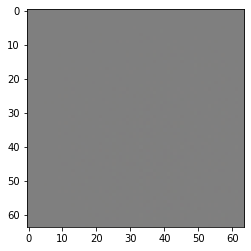

In [ ]:
# Feed noise into G and see what we get

test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img+1)/2)

In [ ]:
# Sampling random images from the dataset

# def get_image_samples(n_samples):
#   return(ds.as_numpy_iterator()[np.random.randint(ds.as_numpy_iterator().shape[0], size=n_samples)])

# plt.imshow((get_image_samples(10)[1]+1)/2)

In [ ]:
# Test D

# print(d(get_image_samples(1)))

In [ ]:
g = Generator()
d = Discriminator()

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_2 (Dense)             (None, 2048)              206848    
                                                                 
 batch_normalization_4 (Batc  (None, 2048)             8192      
 hNormalization)                                                 
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 128)         0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 8, 8, 64)         204864    
 ranspose)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 8, 8, 64)     

In [71]:
import time

g = Generator()
d = Discriminator()

# Training loop

EPOCHS = 100
D_STEPS = 1
G_STEPS = 1
BATCH_SIZE = 128

# Model checkpointing paths
g_cp_path = './g/cp'
d_cp_path = './d/cp'

# Set seed
np.random.seed(1)

# Optimizers
# d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
# g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

# Track current batch iteration
i = 0

# Losses

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=False)

# Format from https://www.tensorflow.org/tutorials/generative/dcgan:
def d_loss(real_predictions, fake_predictions):

  # Track Discriminator predictions
  # real = real_predictions.numpy()[0][0]
  # fake = fake_predictions.numpy()[0][0]
  # print('R:', real)
  # print('F:', fake)
  # if abs(real - fake) < 0.5:
  #   print('Iterations until bug:', i)

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)

  loss = real_loss + fake_loss
  # print('Loss:', loss.numpy())
  return loss

def d_real_loss(real_predictions):

  # Label all real predictions' ground truth as 1, compute b-crossentropy
  real_loss = cross_entropy(tf.ones_like(real_predictions), 
                                                   real_predictions)
  return real_loss

def d_fake_loss(fake_predictions):

  # Label all fake predictions' ground truth as 0, compute b-crossentropy
  fake_loss = cross_entropy(tf.zeros_like(fake_predictions),
                                                   fake_predictions)
  return fake_loss

def print_realandfake_d(data_examples):

  real_pred = d(data_examples)
  fake_pred = d(g(get_noise_samples(1)))  # , Training=True
  # print('NEW R:', real_pred.numpy()[0][0])
  # print('NEW F:', fake_pred.numpy()[0][0])

def g_loss(d_values):

  # Binary Crossentropy between the Discriminator outputs and 1 (which we'd like 
  # the Discriminator outputs to be)
  loss = cross_entropy(tf.ones_like(d_values), d_values)
  return loss

# Training step definitions
# Compiled for training

@tf.function
def d_train_step_real(data_examples):

  # Separate losses from real and fake images so that BatchNorm in D works 
  # Properly.

  with tf.GradientTape() as d_tape_real:

    # Run Discriminator and get loss
    real_loss = d_real_loss(d(data_examples, training=True))

  # Get Discriminator gradients for real loss with GradientTape
  d_real_grad = d_tape_real.gradient(real_loss, d.trainable_variables)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_real_grad, d.trainable_variables))


@tf.function
def d_train_step_fake():

  with tf.GradientTape() as d_tape_fake:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Run Discriminator and get loss
    fake_loss = d_fake_loss(d(g_examples, training=True))

  # Get Discriminator gradients for fake loss with GradientTape
  d_fake_grad = d_tape_fake.gradient(fake_loss, d.trainable_variables)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_fake_grad, d.trainable_variables))


# Toggling @tf.function on will increase performance, but suppress eager 
# execution and prevent logging/displaying to the terminal
@tf.function
def d_train_step(data_examples):

  # Separate losses from real and fake images so that BatchNorm in D works 
  # Properly.

  # with tf.GradientTape() as d_tape_real:

  #   # Run Discriminator and get loss
  #   real_loss = d_real_loss(d(data_examples, training=True))

  # # Get Discriminator gradients for real loss with GradientTape
  # d_real_grad = d_tape_real.gradient(real_loss, d.trainable_variables)

  # # Apply gradients to model, zipping gradients with corresponding variables
  # d_optimizer.apply_gradients(zip(d_real_grad, d.trainable_variables))

  # with tf.GradientTape() as d_tape_fake:

  #   # Sample m noise samples
  #   noise_samples = get_noise_samples(BATCH_SIZE)

  #   # Get Generator examples from the noise
  #   g_examples = g(noise_samples)

  #   # Run Discriminator and get loss
  #   fake_loss = d_fake_loss(d(g_examples, training=True))

  # # Get Discriminator gradients for fake loss with GradientTape
  # d_fake_grad = d_tape_fake.gradient(fake_loss, d.trainable_variables)

  # # Apply gradients to model, zipping gradients with corresponding variables
  # d_optimizer.apply_gradients(zip(d_fake_grad, d.trainable_variables))

  with tf.GradientTape() as d_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator examples from the noise
    g_examples = g(noise_samples)

    # Run Discriminator and get loss
    loss = d_loss(d(data_examples, training=True), 
                       d(g_examples, training=True))

  # Get Discriminator gradients for fake loss with GradientTape
  d_grad = d_tape.gradient(loss, d.trainable_variables)

  # Apply gradients to model, zipping gradients with corresponding variables
  d_optimizer.apply_gradients(zip(d_grad, d.trainable_variables))

  # Print predictions for real and fake after gradient update
  print_realandfake_d(data_examples)

@tf.function
def g_train_step():

  # All steps of the process must be within for backpropagation to work
  with tf.GradientTape() as g_tape:

    # Sample m noise samples
    noise_samples = get_noise_samples(BATCH_SIZE)

    # Get Generator (fake) examples from the noise
    g_examples = g(noise_samples)

    # Run discriminator on generated samples
    d_values = d(g_examples, training=True)

    # Get loss
    loss = g_loss(d_values)

  # Use GradientTape to get all Generator gradients
  g_grad = g_tape.gradient(loss, g.trainable_variables)

  # Apply gradients
  g_optimizer.apply_gradients(zip(g_grad, g.trainable_variables))

# @tf.function
def train_step():

  time_cp = time.time()
  global i
  i = 0
  for batch in ds:

    # Train Discriminator to distinguish between the two
    for j in range(D_STEPS):
      d_train_step(batch)

      # Split for BatchNorm to work properly
      # d_train_step_real(batch)
      # d_train_step_fake()

    # Train Generator to maximize the probability of tricking the discriminator
    for j in range(G_STEPS):
      g_train_step()    

    i += 1
    update_batches = int(12500/128)
    if i % update_batches == 0:
      
      print('Update', i/update_batches, )
      print('Time elapsed for last ' + str(update_batches) + ' batches:', 
            time.time() - time_cp)
      time_cp = time.time()

      # Display generator image
      for img in g(rand_noise_vec, training=False):
        # print(img.numpy())
        plt.imshow((img.numpy()+1)/2)
        plt.show()
    
  # Save weights
  print('Saving Weights...')
  g.save_weights(g_cp_path)
  d.save_weights(d_cp_path) 

Model: "DCGAN_Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_43 (InputLayer)       [(None, 100)]             0         
                                                                 
 dense_42 (Dense)            (None, 16384)             1654784   
                                                                 
 batch_normalization_134 (Ba  (None, 16384)            65536     
 tchNormalization)                                               
                                                                 
 reshape_21 (Reshape)        (None, 4, 4, 1024)        0         
                                                                 
 conv2d_transpose_84 (Conv2D  (None, 8, 8, 512)        13107712  
 Transpose)                                                      
                                                                 
 batch_normalization_135 (Ba  (None, 8, 8, 512)    

Update 1.0
Time elapsed for last 97 batches: 46.4417519569397


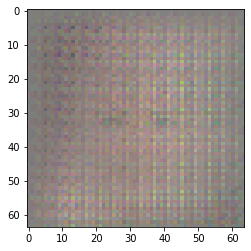

Update 2.0
Time elapsed for last 97 batches: 40.31196331977844


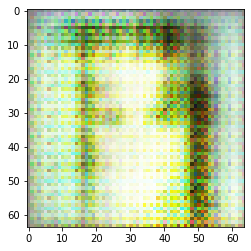

Update 3.0
Time elapsed for last 97 batches: 40.35162806510925


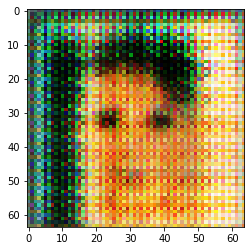

Update 4.0
Time elapsed for last 97 batches: 40.313640832901


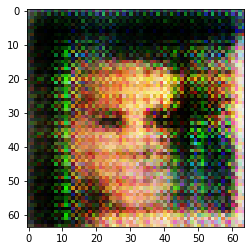

Update 5.0
Time elapsed for last 97 batches: 40.32739973068237


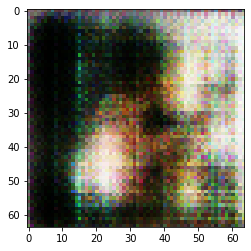

Update 6.0
Time elapsed for last 97 batches: 40.29238677024841


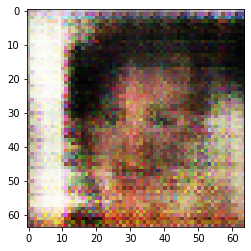

Update 7.0
Time elapsed for last 97 batches: 40.3196587562561


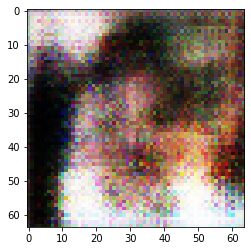

Update 8.0
Time elapsed for last 97 batches: 40.31262969970703


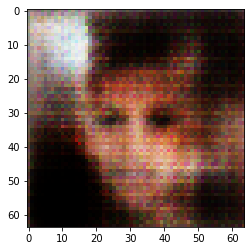

Saving Weights...
EPOCH 0
Update 1.0
Time elapsed for last 97 batches: 42.00530290603638


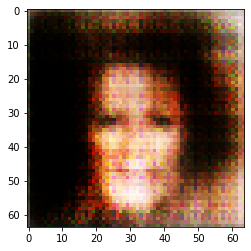

Update 2.0
Time elapsed for last 97 batches: 40.33621597290039


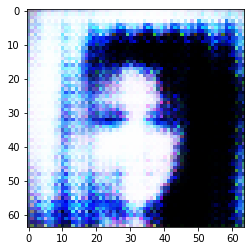

Update 3.0
Time elapsed for last 97 batches: 40.33654022216797


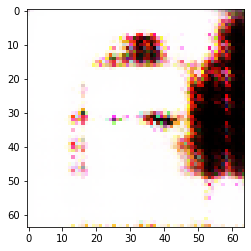

Update 4.0
Time elapsed for last 97 batches: 40.34136414527893


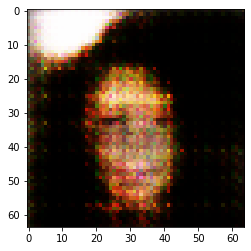

Update 5.0
Time elapsed for last 97 batches: 40.343740940093994


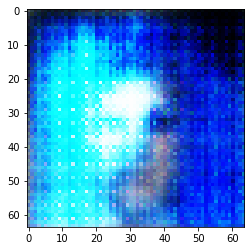

Update 6.0
Time elapsed for last 97 batches: 40.316378593444824


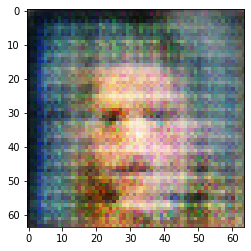

Update 7.0
Time elapsed for last 97 batches: 40.32000684738159


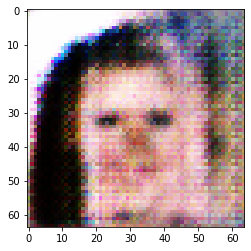

Update 8.0
Time elapsed for last 97 batches: 40.29894542694092


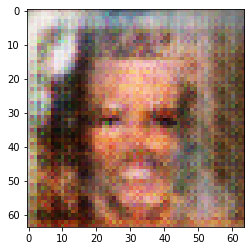

Saving Weights...
EPOCH 1
Update 1.0
Time elapsed for last 97 batches: 42.232436418533325


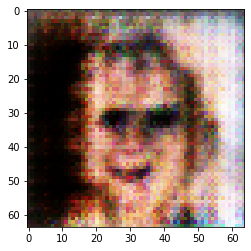

Update 2.0
Time elapsed for last 97 batches: 40.306517601013184


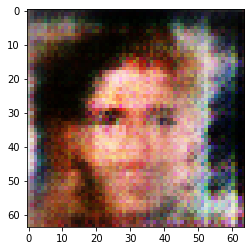

Update 3.0
Time elapsed for last 97 batches: 40.34390830993652


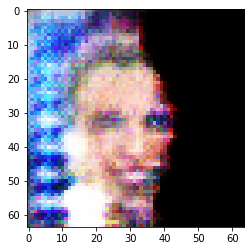

Update 4.0
Time elapsed for last 97 batches: 40.316962003707886


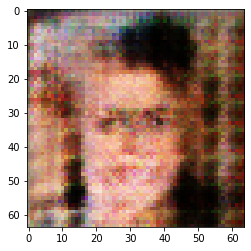

Update 5.0
Time elapsed for last 97 batches: 40.34719371795654


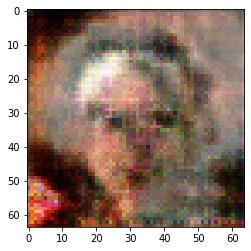

Update 6.0
Time elapsed for last 97 batches: 40.330004930496216


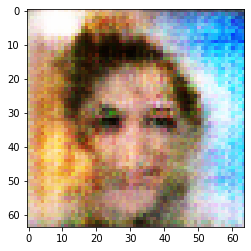

Update 7.0
Time elapsed for last 97 batches: 40.30895495414734


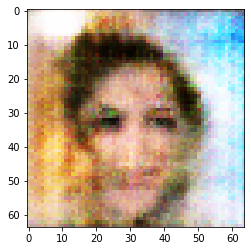

Update 8.0
Time elapsed for last 97 batches: 40.30189037322998


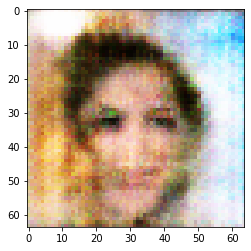

Saving Weights...
EPOCH 2
Update 1.0
Time elapsed for last 97 batches: 42.11903762817383


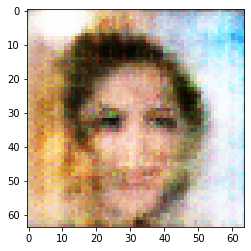

Update 2.0
Time elapsed for last 97 batches: 40.29455804824829


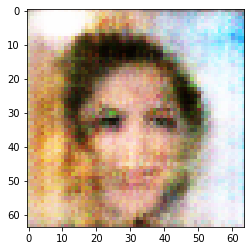

Update 3.0
Time elapsed for last 97 batches: 40.31589984893799


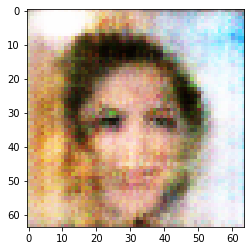

Update 4.0
Time elapsed for last 97 batches: 40.32547163963318


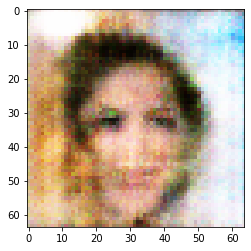

Update 5.0
Time elapsed for last 97 batches: 40.34231233596802


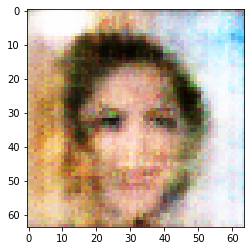

Update 6.0
Time elapsed for last 97 batches: 40.333516359329224


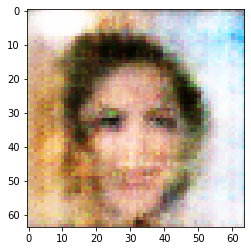

Update 7.0
Time elapsed for last 97 batches: 40.31096029281616


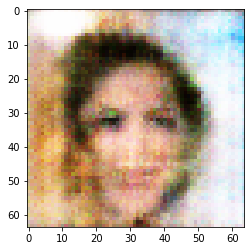

Update 8.0
Time elapsed for last 97 batches: 40.31658220291138


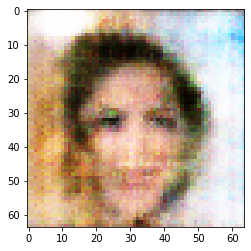

Saving Weights...
EPOCH 3
Update 1.0
Time elapsed for last 97 batches: 42.10574126243591


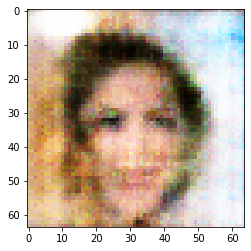

Update 2.0
Time elapsed for last 97 batches: 40.35609292984009


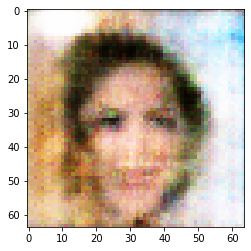

Update 3.0
Time elapsed for last 97 batches: 40.327712535858154


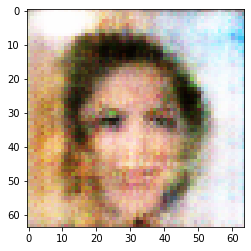

Update 4.0
Time elapsed for last 97 batches: 40.575907945632935


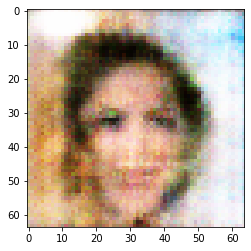

Update 5.0
Time elapsed for last 97 batches: 40.32916069030762


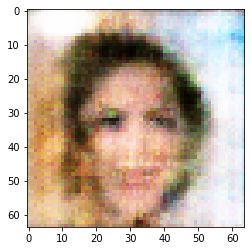

Update 6.0
Time elapsed for last 97 batches: 40.324626445770264


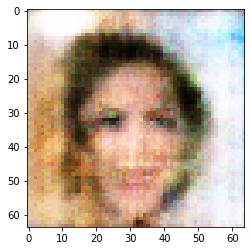

Update 7.0
Time elapsed for last 97 batches: 40.31124663352966


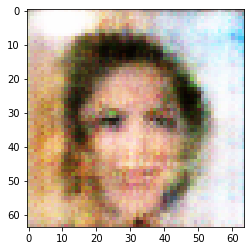

Update 8.0
Time elapsed for last 97 batches: 40.30655646324158


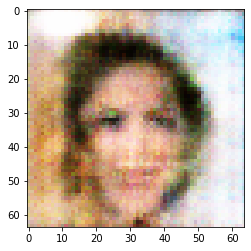

Saving Weights...
EPOCH 4
Update 1.0
Time elapsed for last 97 batches: 42.232929706573486


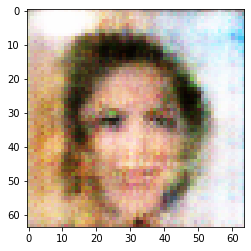

KeyboardInterrupt: ignored

In [72]:
# Train

def train(EPOCHS):

  for i in range(EPOCHS):

    train_step()
    print("EPOCH " + str(i))

train(50)

In [73]:
# Zip and download models

!rm -r models
!mkdir models
!mv d g models
!zip -r /content/models.zip /content/models

from google.colab import files
# files.download("/content/models.zip")


updating: content/models/ (stored 0%)
updating: content/models/d/ (stored 0%)
updating: content/models/d/cp.data-00000-of-00001 (deflated 7%)
updating: content/models/d/checkpoint (deflated 34%)
updating: content/models/d/cp.index (deflated 65%)
updating: content/models/g/ (stored 0%)
updating: content/models/g/cp.data-00000-of-00001 (deflated 8%)
updating: content/models/g/checkpoint (deflated 34%)
updating: content/models/g/cp.index (deflated 64%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_img = g(rand_noise_vec)

print(test_img)

for img in test_img:
  plt.imshow((img + 1)/2)

In [90]:
test_g_sample = g(get_noise_samples(100))
# test_real_sample = get_image_samples(1)

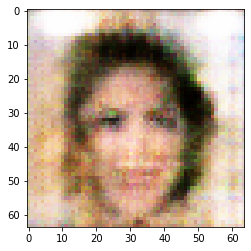

In [101]:
plt.imshow((test_g_sample[99]+1)/2)

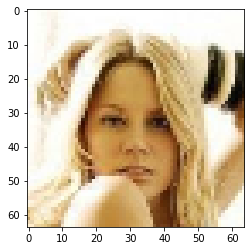

In [ ]:
plt.imshow((test_real_sample[0]+1)/2)

In [ ]:
# Discriminator test

# Note: Since the generator is trained after the discriminator during the sequence, 

fake = 0
real = 0

for i in range(200):
  test_g_sample = g(get_noise_samples(1))
  test_real_sample = get_image_samples(1)
  fake+=d(test_g_sample)
  real+=d(test_real_sample)

print(fake/200.0)
print(real/200.0)

# print(d(test_g_sample))

# print(d(test_real_sample))

# print(d(g(get_noise_samples(1))))

# print(d(get_image_samples(1)))

tf.Tensor([[5.6096707e-07]], shape=(1, 1), dtype=float32)
tf.Tensor([[1.]], shape=(1, 1), dtype=float32)


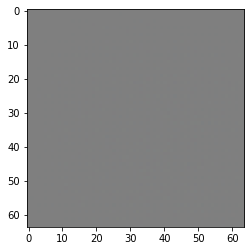

In [ ]:
plt.imshow((g(get_noise_samples(1))[0]+1)/2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


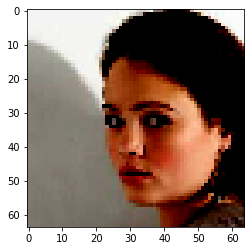

In [ ]:
plt.imshow(data_examples[0])

In [ ]:
# Prepare data

real_ds = tf.keras.utils.image_dataset_from_directory('/content/CelebA/img_align_celeba/', 
                                                      validation_split=0.1, 
                                                      subset='training', seed=1)


Found 0 files belonging to 0 classes.
Using 0 files for training.


ValueError: ignored

In [ ]:
# Load dataset

import tensorflow_datasets as tfds

ds = tfds.load('celeb_a', shuffle_files=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

KeyError: ignored